# 10X scRNA-seq data Xenopus Laevis - Comparison with bulk RNA-seq

November 26, 2020

Repeat after outliers have been removed

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
require("Seurat")

Loading required package: Seurat



In [4]:
# Load scRNA-seq data and split IVF and NT
xenopus.combined <- readRDS(file = "xenopus_combined_and_clustered_no_out.rds")

xenopus.combined.IVF <- subset(xenopus.combined, subset = isnt == "IVF")
xenopus.combined.NT <- subset(xenopus.combined, subset = isnt == "NT")

DefaultAssay(xenopus.combined) <- "RNA"

expmat.IVF <- as.data.frame(GetAssayData(object = xenopus.combined.IVF))
expmat.NT <- as.data.frame(GetAssayData(object = xenopus.combined.NT))
metadata.NT <- xenopus.combined.NT[[]]
metadata.IVF <- xenopus.combined.IVF[[]]

In [5]:
%get expmat.IVF --from R
%get expmat.NT --from R

mean_exp_IVF=pd.DataFrame(expmat_IVF.mean(axis=1))
mean_exp_NT=pd.DataFrame(expmat_NT.mean(axis=1))

mean_exp_IVF=mean_exp_IVF[mean_exp_IVF[0]>0]
mean_exp_NT=mean_exp_NT[mean_exp_NT[0]>0]

Variable expmat.IVF is put to SoS as expmat_IVF
Loading required package: feather

Variable expmat.NT is put to SoS as expmat_NT


In [6]:
# Load the bulk data and select IVF and NT
bulk_data=pd.read_csv("/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/bulk_RNA_seq.csv")
bulk_data = bulk_data.set_index('Row.names')
bulk_data = np.log(bulk_data+1)
# Fix the gene names in the bulk data matrix
new_names=[]

for i in list(bulk_data.index):
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        new_names.append(lst[0])
    else:
        new_names.append(lst[1])
        
bulk_data.index=new_names

# Average duplicated rows in bulk data
bulk_data['Row.names']=bulk_data.index
bulk_data=bulk_data.groupby("Row.names").mean().reset_index()
bulk_data = bulk_data.set_index('Row.names')

RPKM_IVF_cols = [col for col in bulk_data.columns if 'RPKM_IVF' in col]
RPKM_NT_cols = [col for col in bulk_data.columns if 'RPKM_NT' in col]

bulk_data_IVF=bulk_data.loc[:,RPKM_IVF_cols]
bulk_data_NT=bulk_data.loc[:,RPKM_NT_cols]

bulk_data_NT=bulk_data_NT.astype(float)
bulk_data_IVF=bulk_data_IVF.astype(float)

bulk_data_IVF_mean=pd.DataFrame(bulk_data_IVF.mean(axis=1))
bulk_data_NT_mean=pd.DataFrame(bulk_data_NT.mean(axis=1))

bulk_data_IVF_mean=bulk_data_IVF_mean[bulk_data_IVF_mean[0]>0]
bulk_data_NT_mean=bulk_data_NT_mean[bulk_data_NT_mean[0]>0]

print('#genes with mean log(RPKM +1) >0 in bulk')
print('IVF samples','NT samples')
print(len(bulk_data_IVF_mean),len(bulk_data_NT_mean))

print('#genes with mean log(norm. counts +1) > 0 in scRNA-seq')
print('IVF samples','NT samples')
print(len(mean_exp_IVF),len(mean_exp_NT))

# Select only genes found in bulk and sc data
gene_inters_IVF=list(set(bulk_data_IVF_mean.index) & set(mean_exp_IVF.index))
gene_inters_NT=list(set(bulk_data_NT_mean.index) & set(mean_exp_NT.index))

print('#genes studied')
print('IVF','NT')
print(len(gene_inters_IVF),len(gene_inters_NT))


bulk_data_IVF_mean=bulk_data_IVF_mean.loc[gene_inters_IVF,:]
bulk_data_NT_mean=bulk_data_NT_mean.loc[gene_inters_NT,:]

mean_exp_IVF=mean_exp_IVF.loc[gene_inters_IVF,:]
mean_exp_NT=mean_exp_NT.loc[gene_inters_NT,:]

bulk_data_IVF_mean=bulk_data_IVF_mean.reindex(mean_exp_IVF.index)
bulk_data_NT_mean=bulk_data_NT_mean.reindex(mean_exp_NT.index)

<string>:3: RuntimeWarning: invalid value encountered in log


#genes with mean log(RPKM +1) >0 in bulk
IVF samples NT samples
29264 29720
#genes with mean log(norm. counts +1) > 0 in scRNA-seq
IVF samples NT samples
26362 25894
#genes studied
IVF NT
25890 25616


In [7]:
x1=bulk_data_IVF_mean[0]
y1=mean_exp_IVF[0]

x2=bulk_data_NT_mean[0]
y2=mean_exp_NT[0]

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde


def density_scatter_plot(x, y, ax = None, **kwargs):
    """
    :param x: data positions on the x axis
    :param y: data positions on the y axis
    :return: matplotlib.collections.PathCollection object
    """
    
    if ax is None :
        fig , ax = plt.subplots()
    
    # Kernel Density Estimate (KDE)
    values = np.vstack((x, y))
    kernel = gaussian_kde(values)
    kde = kernel.evaluate(values)

    # create array with colors for each data point
    norm = Normalize(vmin=kde.min(), vmax=kde.max())
    colors = cm.ScalarMappable(norm=norm, cmap='viridis').to_rgba(kde)

    # override original color argument
    kwargs['color'] = colors

    #sc=ax.scatter(x, y, **kwargs)
    #sc = ax.scatter(x,y, c=something)
    #cbar=fig.colorbar(sc)
#     cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    #cbar.ax.set_ylabel('Density',fontsize=14)
    sc=ax.scatter(x, y, **kwargs)
    cbar=plt.colorbar(sc,ax=ax)
    cbar.ax.set_ylabel('Density',fontsize=14)

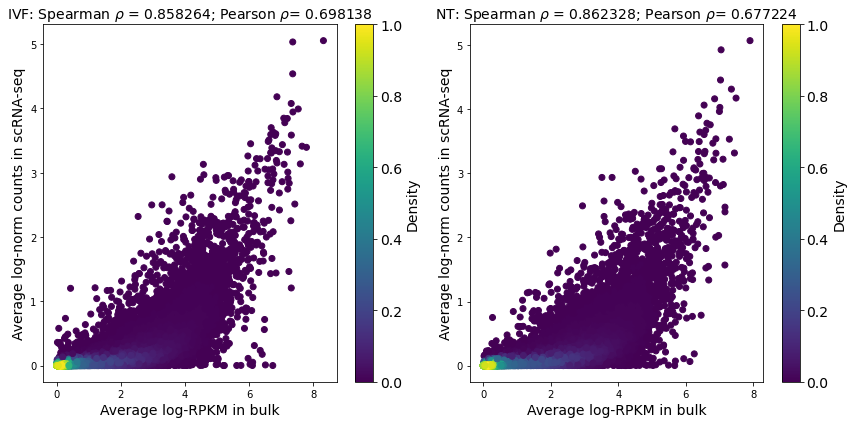

(None, None)

In [9]:
from sklearn.linear_model import LinearRegression

spear_IVF=spearmanr(bulk_data_IVF_mean[0],mean_exp_IVF[0])[0]
pear_IVF=pearsonr(bulk_data_IVF_mean[0],mean_exp_IVF[0])[0]

spear_NT=spearmanr(bulk_data_NT_mean[0],mean_exp_NT[0])[0]
pear_NT=pearsonr(bulk_data_NT_mean[0],mean_exp_NT[0])[0]

# Linear fit for IVF and NT
x_IVF=np.array(bulk_data_IVF_mean[0]).reshape((-1, 1))
x_NT=np.array(bulk_data_NT_mean[0]).reshape((-1, 1))
y_IVF=np.array(mean_exp_IVF[0])
y_NT=np.array(mean_exp_NT[0])

model_IVF = LinearRegression().fit(x_IVF,y_IVF)
model_NT = LinearRegression().fit(x_NT,y_NT)
IVF_pred = model_IVF.predict(x_IVF)
NT_pred = model_NT.predict(x_NT)

fig,ax=plt.subplots(1,2,figsize=(12,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax[0].set_title(r'IVF: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_IVF, pear_IVF), fontsize=14)
ax[0].set_xlabel('Average log-RPKM in bulk', fontsize=14)
ax[0].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
density_scatter_plot(bulk_data_IVF_mean[0],mean_exp_IVF[0],ax=ax[0])
#ax[0].plot(bulk_data_IVF_mean[0],IVF_pred,linewidth=3,color='red')
ax[1].set_title(r'NT: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_NT, pear_NT), fontsize=14)
ax[1].set_xlabel('Average log-RPKM in bulk', fontsize=14)
ax[1].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
density_scatter_plot(bulk_data_NT_mean[0],mean_exp_NT[0],ax=ax[1])
#ax[1].plot(bulk_data_NT_mean[0],NT_pred,linewidth=3,color='red')
fig.tight_layout()
plt.show(),plt.close()

# fig,ax=plt.subplots(1,2,figsize=(12,6))
# plt.rc('xtick',labelsize=14)
# plt.rc('ytick',labelsize=14)
# ax[0].set_title(r'IVF: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_IVF, pear_IVF), fontsize=14)
# ax[0].set_xlabel('Average log-RPKM in bulk', fontsize=14)
# ax[0].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
# ax[0].scatter(bulk_data_IVF_mean[0],mean_exp_IVF[0])
# ax[1].set_title(r'NT: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_NT, pear_NT), fontsize=14)
# ax[1].set_xlabel('Average log-RPKM in bulk', fontsize=14)
# ax[1].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
# ax[1].scatter(bulk_data_NT_mean[0],mean_exp_NT[0])
# fig.tight_layout()
# plt.show(),plt.close()

In [10]:
## Filter genes lowly expressed in bulk
filter_bulk_IVF=bulk_data_IVF_mean[bulk_data_IVF_mean[0]>0.5]
filter_sc_IVF=mean_exp_IVF.loc[filter_bulk_IVF.index]
#filter_sc_IVF=mean_exp_IVF[mean_exp_IVF[0]>0.1]



filter_bulk_NT=bulk_data_NT_mean[bulk_data_NT_mean[0]>0.5]
filter_sc_NT=mean_exp_NT.loc[filter_bulk_NT.index]

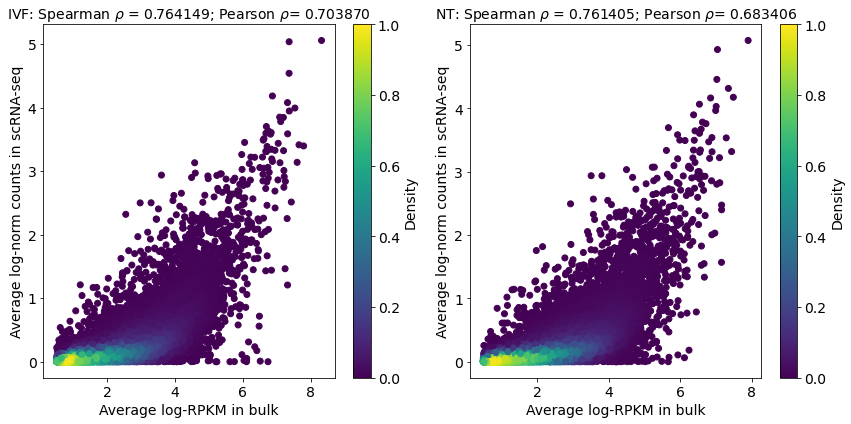

(None, None)

In [11]:
spear_IVF=spearmanr(filter_bulk_IVF[0],filter_sc_IVF[0])[0]
pear_IVF=pearsonr(filter_bulk_IVF[0],filter_sc_IVF[0])[0]

spear_NT=spearmanr(filter_bulk_NT[0],filter_sc_NT[0])[0]
pear_NT=pearsonr(filter_bulk_NT[0],filter_sc_NT[0])[0]

# Linear fit for IVF and NT
x_IVF=np.array(filter_bulk_IVF[0]).reshape((-1, 1))
x_NT=np.array(filter_bulk_NT[0]).reshape((-1, 1))
y_IVF=np.array(filter_sc_IVF[0])
y_NT=np.array(filter_sc_NT[0])

model_IVF = LinearRegression().fit(x_IVF,y_IVF)
model_NT = LinearRegression().fit(x_NT,y_NT)
IVF_pred = model_IVF.predict(x_IVF)
NT_pred = model_NT.predict(x_NT)

fig,ax=plt.subplots(1,2,figsize=(12,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax[0].set_title(r'IVF: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_IVF, pear_IVF), fontsize=14)
ax[0].set_xlabel('Average log-RPKM in bulk', fontsize=14)
ax[0].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
density_scatter_plot(filter_bulk_IVF[0],filter_sc_IVF[0],ax=ax[0])
#ax[0].plot(filter_bulk_IVF[0],IVF_pred,linewidth=3,color='red')
ax[1].set_title(r'NT: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_NT, pear_NT), fontsize=14)
ax[1].set_xlabel('Average log-RPKM in bulk', fontsize=14)
ax[1].set_ylabel('Average log-norm counts in scRNA-seq', fontsize=14)
density_scatter_plot(filter_bulk_NT[0],filter_sc_NT[0],ax=ax[1])
#ax[1].plot(filter_bulk_NT[0],NT_pred,linewidth=3,color='red')
fig.tight_layout()
plt.show(),plt.close()

In [12]:
print('#genes with mean log(RPKM +1)  in bulk')
print('IVF samples','NT samples')
print(len(filter_bulk_IVF),len(filter_bulk_NT))

print('#genes with mean log(norm. counts +1) > 0 in scRNA-seq')
print('IVF samples','NT samples')
print(len(filter_sc_IVF),len(filter_sc_NT))

# Select only genes found in bulk and sc data
filter_gene_inters_IVF=list(set(filter_bulk_IVF.index) & set(filter_sc_IVF.index))
filter_gene_inters_NT=list(set(filter_bulk_NT.index) & set(filter_sc_NT.index))

print('#genes studied')
print('IVF','NT')
print(len(filter_gene_inters_IVF),len(filter_gene_inters_NT))

#genes with mean log(RPKM +1)  in bulk
IVF samples NT samples
15863 16601
#genes with mean log(norm. counts +1) > 0 in scRNA-seq
IVF samples NT samples
15863 16601
#genes studied
IVF NT
15863 16601


# Comparison for the ON-memory genes

In [13]:
import pandas as pd

ON_mem_df=pd.read_csv('EndoNT_Filter_DonorsvsIVFdownFDR_DonsRPKM1_IVFvsNT_FDRup__OnMemFDR.csv')

ON_mem_old=list(ON_mem_df['Row.names'])

ON_mem_new=[]

for i in ON_mem_old:
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        ON_mem_new.append(lst[0])
    else:
        ON_mem_new.append(lst[1])
        
OFF_mem_df=pd.read_csv('EndoNT_Filter_DonorsvsIVFupFDR_IVFvsNT_FDRdown__OffMemFDR.csv')

OFF_mem_old=list(OFF_mem_df['Row.names'])

OFF_mem_new=[]

for i in OFF_mem_old:
    lst=i.split('_')
    if 'unnamed' in lst[1]:
        OFF_mem_new.append(lst[0])
    else:
        OFF_mem_new.append(lst[1])

Note 1: there are 1089 ON-memory genes defined from the bulk RNA-seq data. 1082 of these have mean larger than 0 in both bulk and scRNA-seq data (looking only at nuclear transfer now).

Note 2: there are 1065 OFF-memory genes defined from the bulk RNA-seq data. 1052 of these have mean larger than 0 in both bulk and scRNA-seq data (looking only at IVF now).

1082


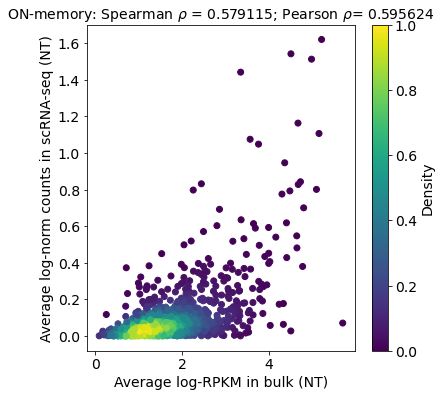

(None, None)

In [14]:
inters_ON_memory=set(bulk_data_NT_mean.index) & set(ON_mem_new)
print(len(inters_ON_memory))

bulk_ON_memory_mean=bulk_data_NT_mean.loc[inters_ON_memory]
sc_ON_memory_mean=mean_exp_NT.loc[inters_ON_memory]

spear_ONmem=spearmanr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]
pear_ONmem=pearsonr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'ON-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_ONmem, pear_ONmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (NT)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (NT)', fontsize=14)
density_scatter_plot(bulk_ON_memory_mean[0],sc_ON_memory_mean[0],ax=ax)
plt.show(),plt.close()

1053


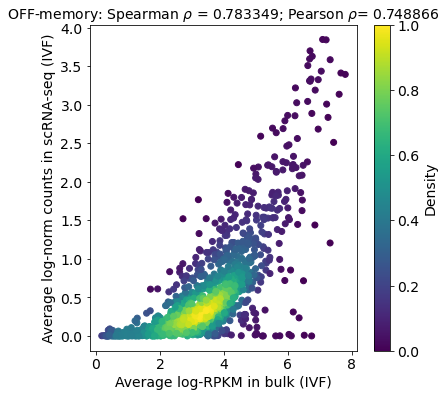

(None, None)

In [15]:
inters_OFF_memory=set(bulk_data_IVF_mean.index) & set(OFF_mem_new)
print(len(inters_OFF_memory))

bulk_OFF_memory_mean=bulk_data_IVF_mean.loc[inters_OFF_memory]
sc_OFF_memory_mean=mean_exp_IVF.loc[inters_OFF_memory]

spear_OFFmem=spearmanr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]
pear_OFFmem=pearsonr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'OFF-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_OFFmem, pear_OFFmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (IVF)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (IVF)', fontsize=14)
density_scatter_plot(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0],ax=ax)
plt.show(),plt.close()

## Check ON- and OFF- memory genes tested in DE analysis

We consider:
    
- ON- and OFF- memory genes tested in all the clusters

- ON- and OFF- memory genes tested in any cluster

- We look at the expression of the remaining ON- and OFF- memory genes in the different cell types

In [16]:
DE_IVF_NT_folder='/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/Data_analysis/DE_IVF_NT_single_clusters/'

res0=pd.read_csv(DE_IVF_NT_folder+'res0.csv',index_col=0)
res1=pd.read_csv(DE_IVF_NT_folder+'res1.csv',index_col=0)
res2=pd.read_csv(DE_IVF_NT_folder+'res2.csv',index_col=0)
res3=pd.read_csv(DE_IVF_NT_folder+'res3.csv',index_col=0)
res4=pd.read_csv(DE_IVF_NT_folder+'res4.csv',index_col=0)
res5=pd.read_csv(DE_IVF_NT_folder+'res5.csv',index_col=0)
res6=pd.read_csv(DE_IVF_NT_folder+'res6.csv',index_col=0)
res7=pd.read_csv(DE_IVF_NT_folder+'res7.csv',index_col=0)
res8=pd.read_csv(DE_IVF_NT_folder+'res8.csv',index_col=0)
res9=pd.read_csv(DE_IVF_NT_folder+'res9.csv',index_col=0)

res0_tested_ON_mem=list(set(ON_mem_new) & set(res0.index))
res1_tested_ON_mem=list(set(ON_mem_new) & set(res1.index))
res2_tested_ON_mem=list(set(ON_mem_new) & set(res2.index))
res3_tested_ON_mem=list(set(ON_mem_new) & set(res3.index))
res4_tested_ON_mem=list(set(ON_mem_new) & set(res4.index))
res5_tested_ON_mem=list(set(ON_mem_new) & set(res5.index))
res6_tested_ON_mem=list(set(ON_mem_new) & set(res6.index))
res7_tested_ON_mem=list(set(ON_mem_new) & set(res7.index))
res8_tested_ON_mem=list(set(ON_mem_new) & set(res8.index))
res9_tested_ON_mem=list(set(ON_mem_new) & set(res9.index))

lst_tested_ON_mem=[res0_tested_ON_mem,res1_tested_ON_mem,res2_tested_ON_mem,
                  res3_tested_ON_mem,res4_tested_ON_mem,res5_tested_ON_mem,
                  res6_tested_ON_mem,res7_tested_ON_mem,res8_tested_ON_mem,
                  res9_tested_ON_mem]

res0_no_tested_ON_mem=list(set(ON_mem_new) - set(res0_tested_ON_mem))
res1_no_tested_ON_mem=list(set(ON_mem_new) - set(res1_tested_ON_mem))
res2_no_tested_ON_mem=list(set(ON_mem_new) - set(res2_tested_ON_mem))
res3_no_tested_ON_mem=list(set(ON_mem_new) - set(res3_tested_ON_mem))
res4_no_tested_ON_mem=list(set(ON_mem_new) - set(res4_tested_ON_mem))
res5_no_tested_ON_mem=list(set(ON_mem_new) - set(res5_tested_ON_mem))
res6_no_tested_ON_mem=list(set(ON_mem_new) - set(res6_tested_ON_mem))
res7_no_tested_ON_mem=list(set(ON_mem_new) - set(res7_tested_ON_mem))
res8_no_tested_ON_mem=list(set(ON_mem_new) - set(res8_tested_ON_mem))
res9_no_tested_ON_mem=list(set(ON_mem_new) - set(res9_tested_ON_mem))

res0_tested_OFF_mem=list(set(OFF_mem_new) & set(res0.index))
res1_tested_OFF_mem=list(set(OFF_mem_new) & set(res1.index))
res2_tested_OFF_mem=list(set(OFF_mem_new) & set(res2.index))
res3_tested_OFF_mem=list(set(OFF_mem_new) & set(res3.index))
res4_tested_OFF_mem=list(set(OFF_mem_new) & set(res4.index))
res5_tested_OFF_mem=list(set(OFF_mem_new) & set(res5.index))
res6_tested_OFF_mem=list(set(OFF_mem_new) & set(res6.index))
res7_tested_OFF_mem=list(set(OFF_mem_new) & set(res7.index))
res8_tested_OFF_mem=list(set(OFF_mem_new) & set(res8.index))
res9_tested_OFF_mem=list(set(OFF_mem_new) & set(res9.index))

lst_tested_OFF_mem=[res0_tested_OFF_mem,res1_tested_OFF_mem,res2_tested_OFF_mem,
                  res3_tested_OFF_mem,res4_tested_OFF_mem,res5_tested_OFF_mem,
                  res6_tested_OFF_mem,res7_tested_OFF_mem,res8_tested_OFF_mem,
                  res9_tested_OFF_mem]

res0_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res0_tested_OFF_mem))
res1_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res1_tested_OFF_mem))
res2_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res2_tested_OFF_mem))
res3_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res3_tested_OFF_mem))
res4_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res4_tested_OFF_mem))
res5_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res5_tested_OFF_mem))
res6_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res6_tested_OFF_mem))
res7_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res7_tested_OFF_mem))
res8_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res8_tested_OFF_mem))
res9_no_tested_OFF_mem=list(set(OFF_mem_new) - set(res9_tested_OFF_mem))

all_tested_ON_mem=list(set(res0_tested_ON_mem) & set(res1_tested_ON_mem) & set(res2_tested_ON_mem) & set(res3_tested_ON_mem) & set(res4_tested_ON_mem) & set(res5_tested_ON_mem) & set(res6_tested_ON_mem) & set(res7_tested_ON_mem) & set(res8_tested_ON_mem) & set(res9_tested_ON_mem))
all_no_tested_ON_mem=list(set(res0_no_tested_ON_mem) & set(res1_no_tested_ON_mem) & set(res2_no_tested_ON_mem) & set(res3_no_tested_ON_mem) & set(res4_no_tested_ON_mem) & set(res5_no_tested_ON_mem) & set(res6_no_tested_ON_mem) & set(res7_no_tested_ON_mem) & set(res8_no_tested_ON_mem) & set(res9_no_tested_ON_mem))
rest_tested_ON_mem=set(list(set().union(*lst_tested_ON_mem))) - set(all_tested_ON_mem)

all_tested_OFF_mem=list(set(res0_tested_OFF_mem) & set(res1_tested_OFF_mem) & set(res2_tested_OFF_mem) & set(res3_tested_OFF_mem) & set(res4_tested_OFF_mem) & set(res5_tested_OFF_mem) & set(res6_tested_OFF_mem) & set(res7_tested_OFF_mem) & set(res8_tested_OFF_mem) & set(res9_tested_OFF_mem))
all_no_tested_OFF_mem=list(set(res0_no_tested_OFF_mem) & set(res1_no_tested_OFF_mem) & set(res2_no_tested_OFF_mem) & set(res3_no_tested_OFF_mem) & set(res4_no_tested_OFF_mem) & set(res5_no_tested_OFF_mem) & set(res6_no_tested_OFF_mem) & set(res7_no_tested_OFF_mem) & set(res8_no_tested_OFF_mem) & set(res9_no_tested_OFF_mem))
rest_tested_OFF_mem=set(list(set().union(*lst_tested_OFF_mem))) - set(all_tested_OFF_mem)


print(len(res0.index),len(res0_tested_ON_mem),len(res0_tested_OFF_mem))
print(len(res1.index),len(res1_tested_ON_mem),len(res1_tested_OFF_mem))
print(len(res2.index),len(res2_tested_ON_mem),len(res2_tested_OFF_mem))
print(len(res3.index),len(res3_tested_ON_mem),len(res3_tested_OFF_mem))
print(len(res4.index),len(res4_tested_ON_mem),len(res4_tested_OFF_mem))
print(len(res5.index),len(res5_tested_ON_mem),len(res5_tested_OFF_mem))
print(len(res6.index),len(res6_tested_ON_mem),len(res6_tested_OFF_mem))
print(len(res7.index),len(res7_tested_ON_mem),len(res7_tested_OFF_mem))
print(len(res8.index),len(res8_tested_ON_mem),len(res8_tested_OFF_mem))
print(len(res9.index),len(res9_tested_ON_mem),len(res9_tested_OFF_mem))

print(len(all_tested_ON_mem),len(all_no_tested_ON_mem),len(rest_tested_ON_mem))

print(len(all_tested_OFF_mem),len(all_no_tested_OFF_mem),len(rest_tested_OFF_mem))


10210 474 860
11146 550 870
10689 497 869
8733 373 817
10417 498 870
9231 384 843
8090 314 808
8752 365 806
9278 398 831
10003 485 844
253 410 426
761 144 160


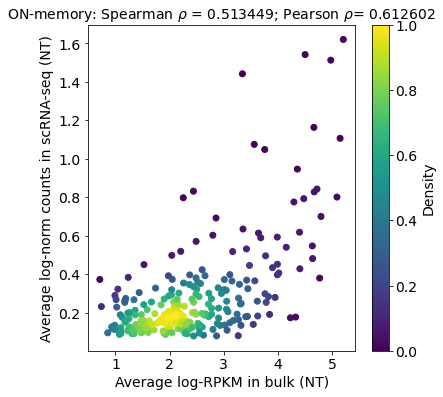

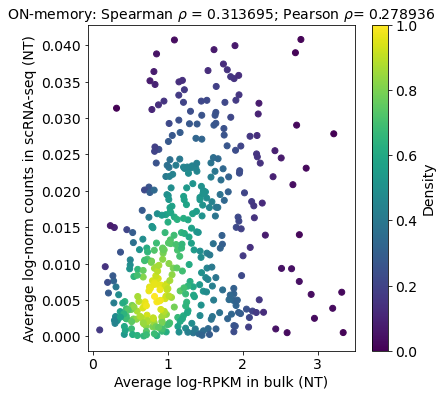

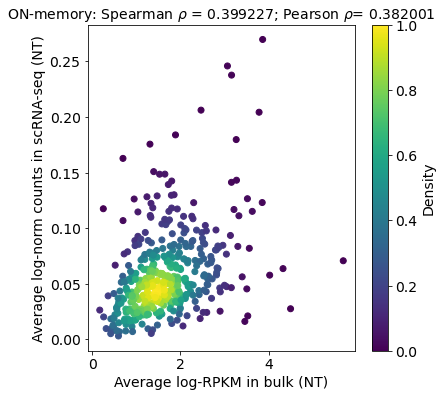

(None, None)

In [17]:
# inters_ON_memory=set(bulk_data_NT_mean.index) & set(ON_mem_new)
# print(len(inters_ON_memory))

bulk_ON_memory_mean=bulk_data_NT_mean.loc[list(set(all_tested_ON_mem) & set(inters_ON_memory))]
sc_ON_memory_mean=mean_exp_NT.loc[list(set(all_tested_ON_mem) & set(inters_ON_memory))]

spear_ONmem=spearmanr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]
pear_ONmem=pearsonr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'ON-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_ONmem, pear_ONmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (NT)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (NT)', fontsize=14)
density_scatter_plot(bulk_ON_memory_mean[0],sc_ON_memory_mean[0],ax=ax)
plt.show(),plt.close()

bulk_ON_memory_mean=bulk_data_NT_mean.loc[list(set(all_no_tested_ON_mem) & set(inters_ON_memory))]
sc_ON_memory_mean=mean_exp_NT.loc[list(set(all_no_tested_ON_mem) & set(inters_ON_memory))]

spear_ONmem=spearmanr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]
pear_ONmem=pearsonr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'ON-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_ONmem, pear_ONmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (NT)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (NT)', fontsize=14)
density_scatter_plot(bulk_ON_memory_mean[0],sc_ON_memory_mean[0],ax=ax)
plt.show(),plt.close()

bulk_ON_memory_mean=bulk_data_NT_mean.loc[list(set(rest_tested_ON_mem) & set(inters_ON_memory))]
sc_ON_memory_mean=mean_exp_NT.loc[list(set(rest_tested_ON_mem) & set(inters_ON_memory))]

spear_ONmem=spearmanr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]
pear_ONmem=pearsonr(bulk_ON_memory_mean[0],sc_ON_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'ON-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_ONmem, pear_ONmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (NT)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (NT)', fontsize=14)
density_scatter_plot(bulk_ON_memory_mean[0],sc_ON_memory_mean[0],ax=ax)
plt.show(),plt.close()

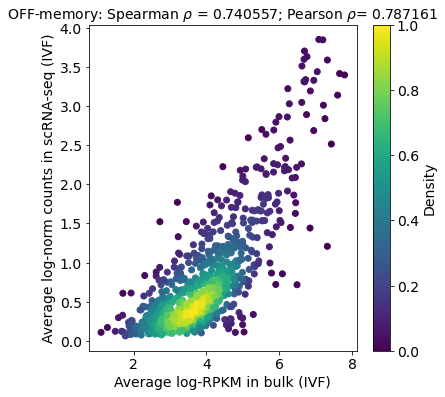

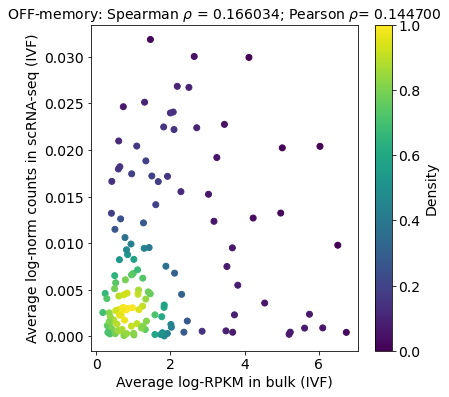

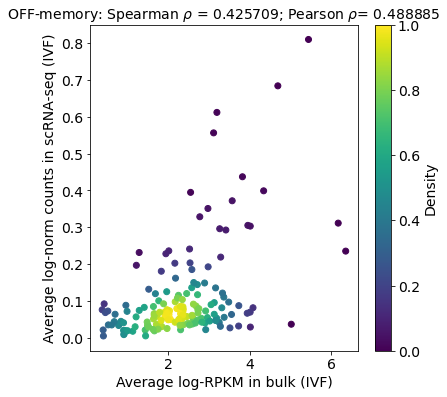

(None, None)

In [18]:
# inters_ON_memory=set(bulk_data_NT_mean.index) & set(ON_mem_new)
# print(len(inters_ON_memory))

bulk_OFF_memory_mean=bulk_data_IVF_mean.loc[list(set(all_tested_OFF_mem) & set(inters_OFF_memory))]
sc_OFF_memory_mean=mean_exp_IVF.loc[list(set(all_tested_OFF_mem) & set(inters_OFF_memory))]

spear_OFFmem=spearmanr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]
pear_OFFmem=pearsonr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'OFF-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_OFFmem, pear_OFFmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (IVF)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (IVF)', fontsize=14)
density_scatter_plot(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0],ax=ax)
plt.show(),plt.close()

bulk_OFF_memory_mean=bulk_data_IVF_mean.loc[list(set(all_no_tested_OFF_mem) & set(inters_OFF_memory))]
sc_OFF_memory_mean=mean_exp_IVF.loc[list(set(all_no_tested_OFF_mem) & set(inters_OFF_memory))]

spear_OFFmem=spearmanr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]
pear_OFFmem=pearsonr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'OFF-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_OFFmem, pear_OFFmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (IVF)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (IVF)', fontsize=14)
density_scatter_plot(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0],ax=ax)
plt.show(),plt.close()

bulk_OFF_memory_mean=bulk_data_IVF_mean.loc[list(set(rest_tested_OFF_mem) & set(inters_OFF_memory))]
sc_OFF_memory_mean=mean_exp_IVF.loc[list(set(rest_tested_OFF_mem) & set(inters_OFF_memory))]

spear_OFFmem=spearmanr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]
pear_OFFmem=pearsonr(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0])[0]

fig,ax=plt.subplots(1,figsize=(6,6))
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)
ax.set_title(r'OFF-memory: Spearman $\rho$ = %f; Pearson $\rho$= %f' % (spear_OFFmem, pear_OFFmem), fontsize=14)
ax.set_xlabel('Average log-RPKM in bulk (IVF)', fontsize=14)
ax.set_ylabel('Average log-norm counts in scRNA-seq (IVF)', fontsize=14)
density_scatter_plot(bulk_OFF_memory_mean[0],sc_OFF_memory_mean[0],ax=ax)
plt.show(),plt.close()

In [19]:
rest_ON_genes=list(set(rest_tested_ON_mem) & set(inters_ON_memory))
rest_OFF_genes=list(set(rest_tested_OFF_mem) & set(inters_OFF_memory))

In [20]:
require(scales)

my_color_palette <- hue_pal()(11)[1:10]

#Get Seurat colors of the conditions
p <- Seurat::DimPlot(xenopus.combined, reduction = "umap", 
                     group.by = "stim")
 # Generate the tSNE plot, but save it as an object
pbuild <- ggplot2::ggplot_build(p) # Use ggplot_build to deconstruct the ggplot object
pdata <- pbuild$data[[1]] # Pull the data used for the plot
pdata <-  pdata[order(pdata$group), ] # Order the plot data by group
ucols <- unique(pdata$colour) # Get a vector of unique colors
names(ucols) <- unique(pdata$group) # Add the groups to the vector of colors as names

Loading required package: scales



Variable metadata.NT is put to SoS as metadata_NT
Variable expmat.NT is put to SoS as expmat_NT


(426, 1538)


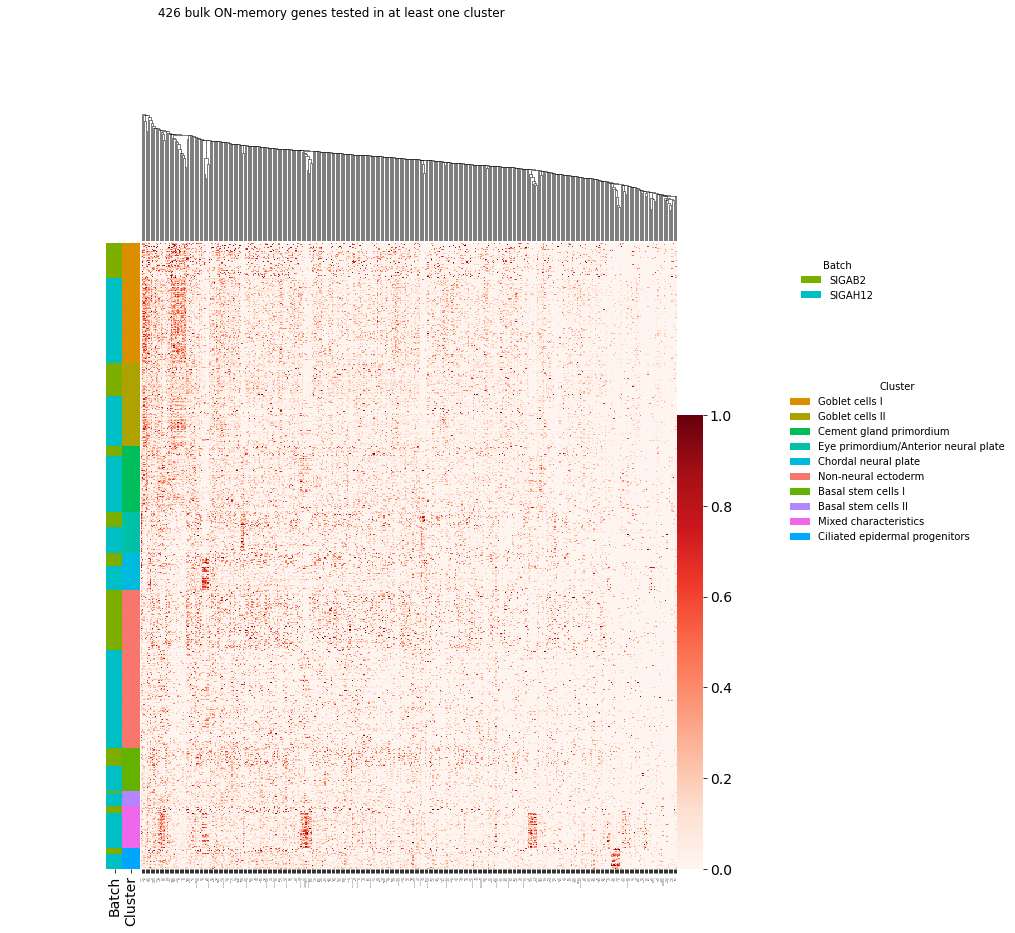

In [25]:
%get metadata.NT --from R
%get expmat.NT --from R
%get my_color_palette --from R
%get ucols --from R
#%get rest_ON_genes


plot_folder='/Users/jonathan/Desktop/MUNCHEN/Project_Xenopus/PLOTS/'

import seaborn as sns
# # Select ON-memory genes with more than 10 counts
# sums=expmat_NT.sum(axis=1)
# sums=sums[sums>np.log(11)]

# expmat_NT=expmat_NT.loc[sums.index]

# nonzeros=(expmat_NT != 0).astype(int).sum(axis=1)
# nonzeros=nonzeros[nonzeros>10]

# ON_mem_filtered=list(set(nonzeros.index) & set(inters_ON_memory))

expmat_NT=expmat_NT.loc[rest_ON_genes]

print(expmat_NT.shape)

expmat_NT=expmat_NT.T
#expmat_NT['seurat_clusters_anno']=list(metadata_NT['seurat_clusters'])
expmat_NT['seurat_clusters_anno']=list(metadata_NT['seurat_clusters'])
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].astype('category')
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].cat.rename_categories([
    'Non-neural ectoderm','Goblet cells I','Goblet cells II','Basal stem cells I',
        'Cement gland primordium','Eye primordium/Anterior neural plate','Chordal neural plate',
         'Ciliated epidermal progenitors','Basal stem cells II','Mixed characteristics'])
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].cat.reorder_categories(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'])
expmat_NT['batch']=list(metadata_NT['stim'])
# expmat_NT['seurat_clusters_anno'] = pd.Categorical(expmat_NT['seurat_clusters_anno'],
#                                          ['Goblet cells I',
#                                           'Goblet cells II',
#                                           'Cement gland primordium',
#                                           'Eye primordium/Anterior neural plate',
#                                           'Chordal neural plate',
#                                           'Non-neural ectoderm',
#                                           'Basal stem cells I',
#                                           'Basal stem cells II',
#                                           'Mixed characteristics',
#                                           'Ciliated epidermal progenitors'])
expmat_NT=expmat_NT.sort_values(by=['seurat_clusters_anno','batch'])
expmat_NT=expmat_NT.set_index(['seurat_clusters_anno'], append=True)
#adata_df=adata_df.set_index('leiden_anno')
expmat_NT=expmat_NT.reindex(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'],
                            level='seurat_clusters_anno')
ld_anno=expmat_NT.index.get_level_values(1)
stg=expmat_NT['batch']
#adata_df=adata_df.drop('leiden_anno',axis=1)
expmat_NT=expmat_NT.drop('batch',axis=1)

my_cols=[my_color_palette[1],my_color_palette[2],my_color_palette[4],
         my_color_palette[5],my_color_palette[6],my_color_palette[0],
         my_color_palette[3],my_color_palette[8],my_color_palette[9],
         my_color_palette[7]]

lut = dict(zip(ld_anno.unique(), my_cols))
col_colors = ld_anno.map(lut)

lut2 = dict(zip(stg.unique(), "rb"))
lut2['SIGAB2']=ucols[1]
lut2['SIGAH12']=ucols[2]
col_colors2 = stg.map(lut2)

data={'Batch': list(col_colors2),'Cluster': list(col_colors)}

anno_df=pd.DataFrame(data=data)
anno_df=anno_df.set_index(expmat_NT.index)


g=sns.clustermap(expmat_NT,row_cluster=False,col_cluster=True,standard_scale=1,cmap='Reds',
                 linecolor='black',
               row_colors=anno_df,yticklabels=False,xticklabels=True,figsize=(12,14))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 1)

g.fig.suptitle('%d bulk ON-memory genes tested in at least one cluster' % (len(rest_ON_genes)))

for label in stg.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut2[label],
                            label=label, linewidth=0)
    
l1 = g.ax_col_dendrogram.legend(title='Batch', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(1.3, -0.3))#, bbox_transform=gcf().transFigure)
for label in ld_anno.unique():
    
    g.ax_row_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)


l2 = g.ax_row_dendrogram.legend(title='Cluster', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(9.15, 0.65))#, bbox_transform=gcf().transFigure)
    

    
#g.ax_col_dendrogram.legend(loc="center", ncol=5,frameon=False)
g.cax.set_position([0.9, 0.125, .03, .45])

plt.savefig(plot_folder+'heatmap_rest_ON_memory_genes.pdf', bbox_inches='tight')

Variable metadata.IVF is put to SoS as metadata_IVF
Variable expmat.IVF is put to SoS as expmat_IVF
Magic %get without option --kernel can only be executed by subkernels


(160, 1826)


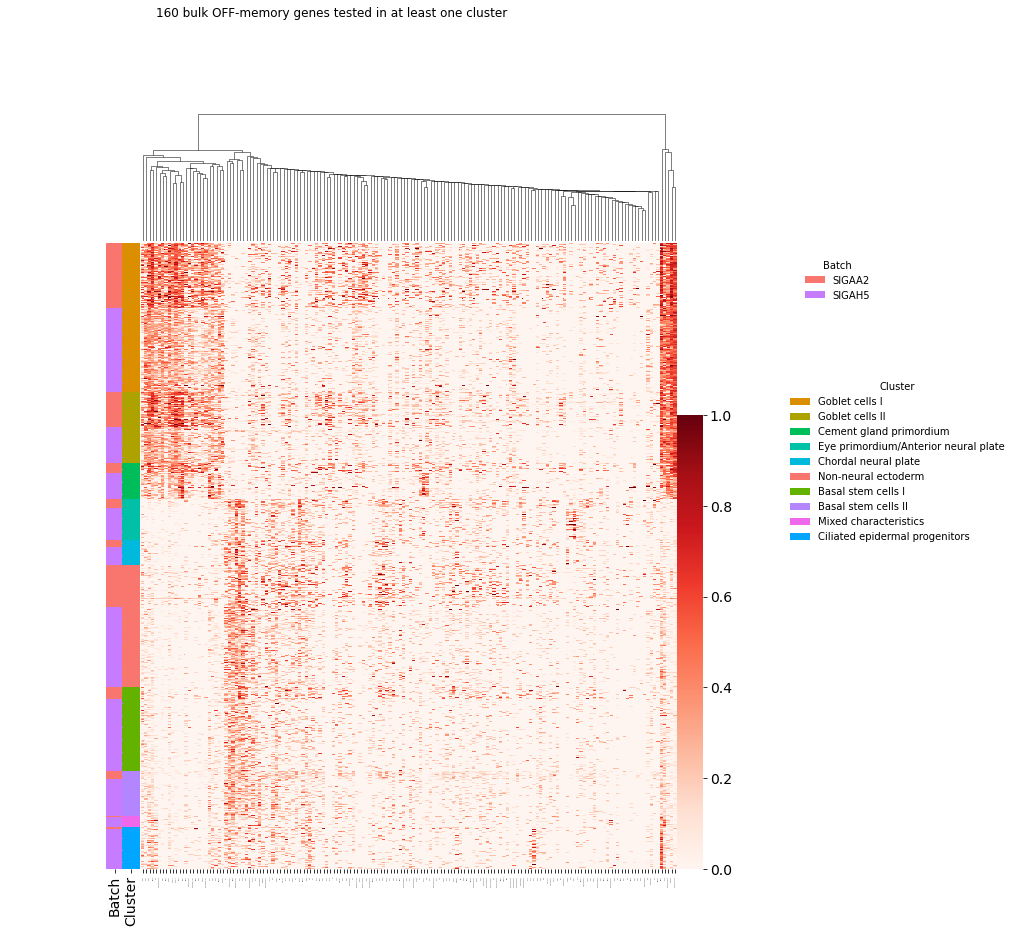

In [26]:
%get metadata.IVF --from R
%get expmat.IVF --from R
%get my_color_palette --from R
%get ucols --from R
%get rest_OFF_genes


import seaborn as sns
# # Select ON-memory genes with more than 10 counts
# sums=expmat_NT.sum(axis=1)
# sums=sums[sums>np.log(11)]

# expmat_NT=expmat_NT.loc[sums.index]

# nonzeros=(expmat_NT != 0).astype(int).sum(axis=1)
# nonzeros=nonzeros[nonzeros>10]

# ON_mem_filtered=list(set(nonzeros.index) & set(inters_ON_memory))

expmat_IVF=expmat_IVF.loc[rest_OFF_genes]

print(expmat_IVF.shape)

expmat_IVF=expmat_IVF.T
#expmat_NT['seurat_clusters_anno']=list(metadata_NT['seurat_clusters'])
expmat_IVF['seurat_clusters_anno']=list(metadata_IVF['seurat_clusters'])
expmat_IVF['seurat_clusters_anno']=expmat_IVF['seurat_clusters_anno'].astype('category')
expmat_IVF['seurat_clusters_anno']=expmat_IVF['seurat_clusters_anno'].cat.rename_categories([
    'Non-neural ectoderm','Goblet cells I','Goblet cells II','Basal stem cells I',
        'Cement gland primordium','Eye primordium/Anterior neural plate','Chordal neural plate',
         'Ciliated epidermal progenitors','Basal stem cells II','Mixed characteristics'])
expmat_IVF['seurat_clusters_anno']=expmat_IVF['seurat_clusters_anno'].cat.reorder_categories(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'])
expmat_IVF['batch']=list(metadata_IVF['stim'])
# expmat_NT['seurat_clusters_anno'] = pd.Categorical(expmat_NT['seurat_clusters_anno'],
#                                          ['Goblet cells I',
#                                           'Goblet cells II',
#                                           'Cement gland primordium',
#                                           'Eye primordium/Anterior neural plate',
#                                           'Chordal neural plate',
#                                           'Non-neural ectoderm',
#                                           'Basal stem cells I',
#                                           'Basal stem cells II',
#                                           'Mixed characteristics',
#                                           'Ciliated epidermal progenitors'])
expmat_IVF=expmat_IVF.sort_values(by=['seurat_clusters_anno','batch'])
expmat_IVF=expmat_IVF.set_index(['seurat_clusters_anno'], append=True)
#adata_df=adata_df.set_index('leiden_anno')
expmat_IVF=expmat_IVF.reindex(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'],
                            level='seurat_clusters_anno')
ld_anno=expmat_IVF.index.get_level_values(1)
stg=expmat_IVF['batch']
#adata_df=adata_df.drop('leiden_anno',axis=1)
expmat_IVF=expmat_IVF.drop('batch',axis=1)

my_cols=[my_color_palette[1],my_color_palette[2],my_color_palette[4],
         my_color_palette[5],my_color_palette[6],my_color_palette[0],
         my_color_palette[3],my_color_palette[8],my_color_palette[9],
         my_color_palette[7]]

lut = dict(zip(ld_anno.unique(), my_cols))
col_colors = ld_anno.map(lut)

lut2 = dict(zip(stg.unique(), "rb"))
lut2['SIGAA2']=ucols[0]
lut2['SIGAH5']=ucols[3]
col_colors2 = stg.map(lut2)

data={'Batch': list(col_colors2),'Cluster': list(col_colors)}

anno_df=pd.DataFrame(data=data)
anno_df=anno_df.set_index(expmat_IVF.index)


g=sns.clustermap(expmat_IVF,row_cluster=False,col_cluster=True,standard_scale=1,cmap='Reds',
                 linecolor='black',
               row_colors=anno_df,yticklabels=False,xticklabels=True,figsize=(12,14))
g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 1)
g.fig.suptitle('%d bulk OFF-memory genes tested in at least one cluster' % (len(rest_OFF_genes)))

for label in stg.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut2[label],
                            label=label, linewidth=0)
    
l1 = g.ax_col_dendrogram.legend(title='Batch', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(1.3, -0.3))#, bbox_transform=gcf().transFigure)
for label in ld_anno.unique():
    
    g.ax_row_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)


l2 = g.ax_row_dendrogram.legend(title='Cluster', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(9.15, 0.65))#, bbox_transform=gcf().transFigure)
    

    
#g.ax_col_dendrogram.legend(loc="center", ncol=5,frameon=False)
g.cax.set_position([0.9, 0.125, .03, .45])

plt.savefig(plot_folder+'heatmap_rest_OFF_memory_genes.pdf', bbox_inches='tight')

## Check ON-memory gene expression in cell types

We filter ON-memory genes expressed in less than 10 cells and with less than 10 counts and we plot their expression per cluster in a heatmap.

Add OFF-memory genes, find a strategy for this analysis

In [125]:
require(scales)

my_color_palette <- hue_pal()(11)[1:10]

#Get Seurat colors of the conditions
p <- Seurat::DimPlot(xenopus.combined, reduction = "umap", 
                     group.by = "stim")
 # Generate the tSNE plot, but save it as an object
pbuild <- ggplot2::ggplot_build(p) # Use ggplot_build to deconstruct the ggplot object
pdata <- pbuild$data[[1]] # Pull the data used for the plot
pdata <-  pdata[order(pdata$group), ] # Order the plot data by group
ucols <- unique(pdata$colour) # Get a vector of unique colors
names(ucols) <- unique(pdata$group) # Add the groups to the vector of colors as names

Variable metadata.NT is put to SoS as metadata_NT
Variable expmat.NT is put to SoS as expmat_NT


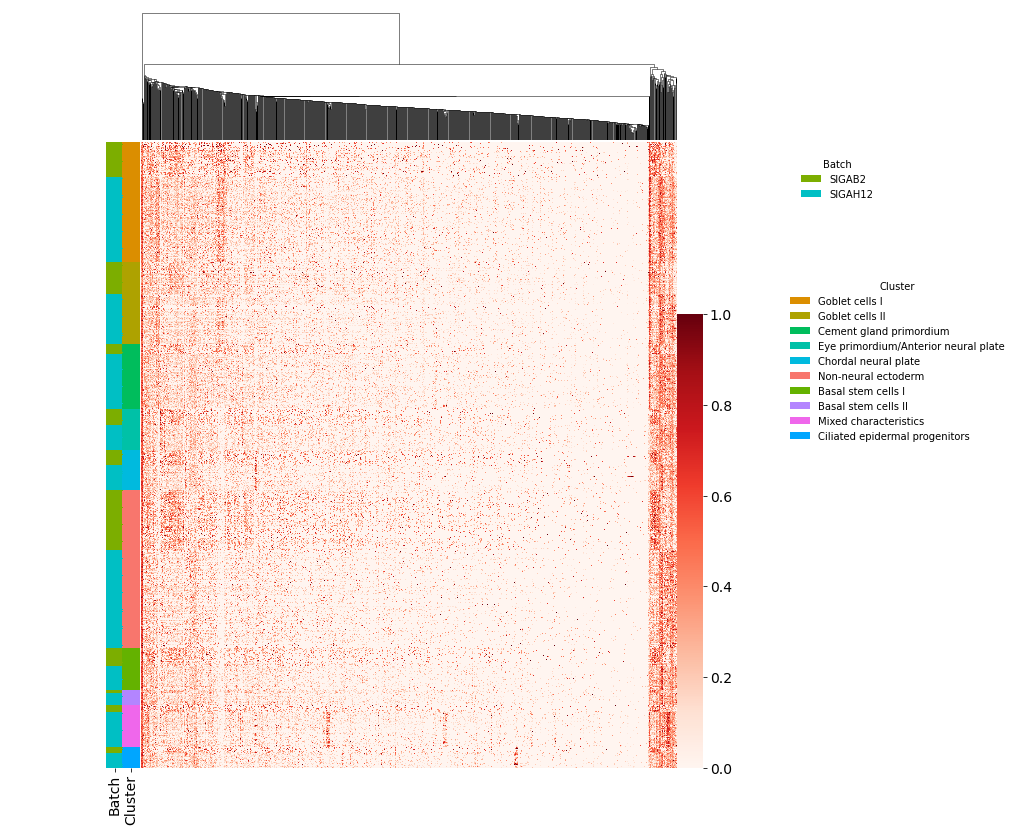

In [126]:
%get metadata.NT --from R
%get expmat.NT --from R
%get my_color_palette --from R
%get ucols --from R

# Select ON-memory genes with more than 10 counts
sums=expmat_NT.sum(axis=1)
sums=sums[sums>np.log(11)]

expmat_NT=expmat_NT.loc[sums.index]

nonzeros=(expmat_NT != 0).astype(int).sum(axis=1)
nonzeros=nonzeros[nonzeros>10]

ON_mem_filtered=list(set(nonzeros.index) & set(inters_ON_memory))

expmat_NT=expmat_NT.loc[ON_mem_filtered]


expmat_NT=expmat_NT.T
#expmat_NT['seurat_clusters_anno']=list(metadata_NT['seurat_clusters'])
expmat_NT['seurat_clusters_anno']=list(metadata_NT['seurat_clusters'])
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].astype('category')
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].cat.rename_categories([
    'Non-neural ectoderm','Goblet cells I','Goblet cells II','Basal stem cells I',
        'Cement gland primordium','Eye primordium/Anterior neural plate','Chordal neural plate',
         'Ciliated epidermal progenitors','Basal stem cells II','Mixed characteristics'])
expmat_NT['seurat_clusters_anno']=expmat_NT['seurat_clusters_anno'].cat.reorder_categories(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'])
expmat_NT['batch']=list(metadata_NT['stim'])
# expmat_NT['seurat_clusters_anno'] = pd.Categorical(expmat_NT['seurat_clusters_anno'],
#                                          ['Goblet cells I',
#                                           'Goblet cells II',
#                                           'Cement gland primordium',
#                                           'Eye primordium/Anterior neural plate',
#                                           'Chordal neural plate',
#                                           'Non-neural ectoderm',
#                                           'Basal stem cells I',
#                                           'Basal stem cells II',
#                                           'Mixed characteristics',
#                                           'Ciliated epidermal progenitors'])
expmat_NT=expmat_NT.sort_values(by=['seurat_clusters_anno','batch'])
expmat_NT=expmat_NT.set_index(['seurat_clusters_anno'], append=True)
#adata_df=adata_df.set_index('leiden_anno')
expmat_NT=expmat_NT.reindex(['Goblet cells I',
                                          'Goblet cells II',
                                          'Cement gland primordium',
                                          'Eye primordium/Anterior neural plate',
                                          'Chordal neural plate',
                                          'Non-neural ectoderm',
                                          'Basal stem cells I',
                                          'Basal stem cells II',
                                          'Mixed characteristics',
                                          'Ciliated epidermal progenitors'],
                            level='seurat_clusters_anno')
ld_anno=expmat_NT.index.get_level_values(1)
stg=expmat_NT['batch']
#adata_df=adata_df.drop('leiden_anno',axis=1)
expmat_NT=expmat_NT.drop('batch',axis=1)

my_cols=[my_color_palette[1],my_color_palette[2],my_color_palette[4],
         my_color_palette[5],my_color_palette[6],my_color_palette[0],
         my_color_palette[3],my_color_palette[8],my_color_palette[9],
         my_color_palette[7]]

lut = dict(zip(ld_anno.unique(), my_cols))
col_colors = ld_anno.map(lut)

lut2 = dict(zip(stg.unique(), "rb"))
lut2['SIGAB2']=ucols[1]
lut2['SIGAH12']=ucols[2]
col_colors2 = stg.map(lut2)

data={'Batch': list(col_colors2),'Cluster': list(col_colors)}

anno_df=pd.DataFrame(data=data)
anno_df=anno_df.set_index(expmat_NT.index)


g=sns.clustermap(expmat_NT,row_cluster=False,col_cluster=True,standard_scale=1,cmap='Reds',
                 linecolor='black',
               row_colors=anno_df,yticklabels=False,xticklabels=False,figsize=(12,14))


for label in stg.unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut2[label],
                            label=label, linewidth=0)
    
l1 = g.ax_col_dendrogram.legend(title='Batch', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(1.3, -0.3))#, bbox_transform=gcf().transFigure)
for label in ld_anno.unique():
    
    g.ax_row_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)


l2 = g.ax_row_dendrogram.legend(title='Cluster', loc="center", ncol=1,frameon=False,
                                bbox_to_anchor=(9.15, 0.65))#, bbox_transform=gcf().transFigure)
    

    
#g.ax_col_dendrogram.legend(loc="center", ncol=5,frameon=False)
g.cax.set_position([0.9, 0.125, .03, .45])

#plt.savefig('heatmap_both_stages.pdf', bbox_inches='tight')

In [156]:
from scipy.cluster.hierarchy import fcluster
import pandas as pd

dgram = g.dendrogram_col.dendrogram
linkageMat=g.dendrogram_col.linkage
ordered_gindices=g.dendrogram_col.reordered_ind

max_d = 10.5
clusters = fcluster(linkageMat, max_d, criterion='distance')
np.amax(clusters)

ON_mem_clustering=pd.DataFrame(data={'clus_labels':clusters},
                               index=expmat_NT.columns[ordered_gindices])

18

It is hard to spot patterns for ON-memory genes expression from this heatmap.

We could cluster the ON-memory genes in the single-cell data and plot:
    
1. A clustermap as the one above for each cluster

2. A dotplot showing the average expression per cell type for each cluster